In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
from torchvision import datasets, transforms


In [23]:
# load patches data from files
# train_images_patches = np.load('data/train_crop25_L2_121_25.npy') # After L2 normalization
# test_images_patches = np.load('data/test_crop25_L2_121_25.npy')
train_images_patches = np.load('data/train_crop25_121_25.npy') # no L2
test_images_patches = np.load('data/test_crop25_121_25.npy')
train_images_patches = torch.from_numpy(train_images_patches)
test_images_patches = torch.from_numpy(test_images_patches)

# get the label from datasets.MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist_offtrain = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_offtest = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_labels = [label for _, label in mnist_offtrain]
test_labels = [label for _, label in mnist_offtest]
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)

# make them to be PyTorch tensors, and dataloader
# train_dataset = torch.utils.data.TensorDataset(train_images_patches[:100], train_labels[:100])
# test_dataset = torch.utils.data.TensorDataset(test_images_patches[:100], test_labels[:100])
# train_dataset = torch.utils.data.TensorDataset(train_images_patches, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_images_patches, test_labels)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)


In [3]:
def write_debug(header:str, debug_npy:np.array):
    # convert numpy array to string
    debug_str = ''
    for i in range(debug_npy.shape[0]):
        for j in range(debug_npy.shape[1]):
            debug_str += str(debug_npy[i][j])[0:5] + ' '
        debug_str += '\n'
        
    # write debug_str to debug.txt
    with open('debug/debug.txt', 'a') as f:
        f.write(header+': \t'+debug_str + '\n')

In [4]:
# clear debug.txt
with open('debug/debug.txt', 'w') as f:
    f.write('')

class Script_DiaNet(nn.Module):

    def __init__(self, inp_num, out_num, device='cpu'):
        super(Script_DiaNet, self).__init__()
        self.log = False
        
        self.red_depths = list(range(2, 1000))
        self.red_fulls = [sum(range(1, n+2)) for n in self.red_depths]
        self.red_heads = [(x * 2) + 1 for x in self.red_depths]

        self.red_full = -1
        self.red_dep = -1
        self.red_triangle = []
        self.layers, self.masks = self.gen_layers(inp_num, out_num)
        # each mask to device
        for i in range(len(self.masks)):
            self.masks[i] = self.masks[i].to(device)
        # each layers multiply mask
        self.x_hidden = []
        for i in range(len(self.layers)):
            self.layers[i].weight.data = self.layers[i].weight.data * self.masks[i]
            self.x_hidden.append(-1) # init x_hidden
        
    
    def select_insert(self, n, sel_len) -> list:
        assert (((n - 1) // 2) % 2) == (sel_len % 2), "Invalid selection length"
        numbers = range(n)
        odd_numbers = [num for num in numbers if num % 2 == 1]
        center_index = len(odd_numbers) // 2
        selected_numbers = odd_numbers[center_index - sel_len // 2: center_index + sel_len // 2 + (sel_len % 2)]
        return selected_numbers if sel_len != 1 else selected_numbers
        
    def gen_layers(self, inp_num, out_num):
        # create Red triangle(input triangle)
        masks_list = []

        # select input triangle by input num
        red_dep, red_head = -1, -1
        for i in range(len(self.red_fulls)-1):
            if inp_num > self.red_fulls[i] and inp_num <= self.red_fulls[i+1]:
                red_full = self.red_fulls[i+1]
                red_dep = self.red_depths[i+1]
                red_head = self.red_heads[i+1]
                if self.log: print("red_dep:", red_dep, "red_head:", red_head)
                break
        assert (red_dep>0)and(red_head>0), "red_dep {} or head {} is not valid".format(red_dep, red_head)
        self.red_dep = red_dep
        self.red_full = red_full
        for i in range(red_dep, 0, -1):
            if i == red_dep:
                self.red_triangle.append(i*2+1)
            else:
                self.red_triangle.append(i)

        
        # create blue triangle(output triangle)
        nn_output = out_num + (out_num-1)
        blue_dep = int(nn_output/2-0.5)
        if self.log:print("blue_dep:", blue_dep)

        total_dep = red_dep + blue_dep
        if self.log:print("total_dep:", total_dep)

        # expand times
        expand_times = total_dep - red_dep
        if self.log:print("expand_times:", expand_times)

        # create expand time nn layer
        expand_list = []
        expand_list.append(nn.Linear(red_head, red_head-2, bias=False)) # first layer
        masks_list.append(self.fst_mask(red_head, red_head-2))
        nn_in = red_head-2
        for i in range(expand_times):
            expand_list.append(nn.Linear(nn_in, nn_in+2, bias=False))
            masks_list.append(self.exp_mask(nn_in, nn_in+2))
            nn_in += 2
        if self.log:print("expand_list:", expand_list)

        # shrink times
        shrink_times = total_dep - blue_dep - 1
        # if self.log:print("shrink_times:", shrink_times)
        shrink_list = []
        for i in range(shrink_times):
            shrink_list.append(nn.Linear(nn_in, nn_in-2, bias=False))
            masks_list.append(self.shr_mask(nn_in, nn_in-2))
            nn_in -= 2
        if self.log:print("shrink_list:", shrink_list)

        # combine expand and shrink list
        layer_list = expand_list + shrink_list
        layers = nn.Sequential(*layer_list)
        assert len(masks_list) == len(layer_list), "masks_list {} and layer_list {} is not same".format(len(masks_list), len(layer_list))

        return layers, masks_list
    
    def fst_mask(self, in_dim, out_dim):
        assert in_dim-out_dim == 2, "fst_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
        mask = torch.zeros((out_dim, in_dim))
        for i in range(out_dim):
            if i%2 == 0:
                start_idx = i
                end_idx = i+2 + 1
                mask[i, start_idx:end_idx] = 1
        return mask
    
    def exp_mask(self, in_dim, out_dim):
        assert out_dim-in_dim == 2, "exp_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
        mask = torch.zeros((out_dim, in_dim))
        for i in range(out_dim):
            if i%2 == 0:
                a = max(0, i-4)
                b = min(max(0, i-2), in_dim-1)
                c = min(max(0, i-1), in_dim-1)
                d = min(max(0, i), in_dim-1)
                e = min(max(0, i+2), in_dim-1)
                idx_lis = [a,b,c,d,e]
                mask[i, idx_lis] = 1
        return mask
    
    def shr_mask(self, in_dim, out_dim):
        assert in_dim-out_dim == 2, "shr_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
        mask = torch.zeros((out_dim, in_dim))
        for i in range(out_dim):
            if i%2 == 0:
                a = max(0, i-2)
                b = min(max(0, i), in_dim-1)
                c = min(max(0, i+1), in_dim-1)
                d = min(max(0, i+2), in_dim-1)
                e = min(max(0, i+4), in_dim-1)
                idx_lis = [a,b,c,d,e]
                mask[i, idx_lis] = 1
        return mask
                
    def forward(self, x):
        container = torch.zeros((x.shape[0], self.red_full)) # (b, 28)
        container[:, 0:x.shape[1]] = x
        # split x for red triangle, froexample, 25-> 13,5,4,3,2,1
        x_seg = []
        slice_idx = 0
        for i in range(self.red_dep, 0, -1):
            if i == self.red_dep:
                x_seg.append(container[:, 0:i*2+1]) # 13
                slice_idx += i*2+1
            else:
                x_seg.append(container[:, slice_idx:slice_idx+i]) # 13:18, 18:22, 22:25, 25:27, 27:28
                slice_idx += i
        if self.log: 
            for seg in x_seg: print(seg)
        if self.log: print('*'*30)

        for i, layer in enumerate(self.layers):
            # red triangle stage
            if i == 0:
                layer.weight.data = torch.clamp(layer.weight.data, min=-1, max=1)
                layer.weight.data *= self.masks[i]
                x = layer(x_seg[i])
                x = torch.tanh(x)
                if self.log: write_debug('layer{}, x'.format(i), x.detach().numpy())
                self.x_hidden[i] = x
            
            elif i == 1:
                if self.log: write_debug('layer{}, x'.format(i), x.detach().numpy())
                assert torch.sum(x[:, 1::2]) == 0, "x[:, 1::2] is not 0"
                layer.weight.data = torch.clamp(layer.weight.data, min=-1, max=1)
                layer.weight.data *= self.masks[i]
                x_cpy = x.clone()
                this_len, red_tri_layer_num = x_cpy.shape[1], self.red_triangle[i]
                sel_insert = self.select_insert(this_len, red_tri_layer_num)
                # if self.log: print("sel_insert:", sel_insert)
                assert x_cpy[:, sel_insert].shape == x_seg[i].shape, "x_cpy[:, sel_insert] shape {} and x_seg[i] shape {} is not same".format(x_cpy[:, sel_insert].shape, x_seg[i].shape)
                if self.log: write_debug('layer{}, seg'.format(i), x_seg[i].detach().numpy())
                x_cpy[:, sel_insert] += x_seg[i]
                x = x_cpy
                if self.log: write_debug('layer{}, x insrt'.format(i), x.detach().numpy())
                x = layer(x)
                x = torch.tanh(x)
                self.x_hidden[i] = x

            elif i > 1 and i < self.red_dep:
                if self.log: write_debug('layer{}, x'.format(i), x.detach().numpy())
                assert torch.sum(x[:, 1::2]) == 0, "x[:, 1::2] is not 0"
                layer.weight.data = torch.clamp(layer.weight.data, min=-1, max=1)
                layer.weight.data *= self.masks[i]
                x_cpy = x.clone()
                this_len = x_cpy.shape[1]
                red_tri_layer_num = self.red_triangle[i]
                sel_insert = self.select_insert(this_len, red_tri_layer_num)
                # if self.log: print("sel_insert:", sel_insert)
                assert x_cpy[:, sel_insert].shape == x_seg[i].shape, "x_cpy[:, sel_insert] shape {} and x_seg[i] shape {} is not same".format(x_cpy[:, sel_insert].shape, x_seg[i].shape)
                if self.log: write_debug('layer{}, seg'.format(i), x_seg[i].detach().numpy())
                # insert input segment to x_cpy
                x_cpy[:, sel_insert] += x_seg[i]
                x = x_cpy
                if self.log: write_debug('layer{}, x insrt'.format(i), x.detach().numpy())
                x = layer(x)
                if self.log: write_debug('layer{}, x fc'.format(i), x.detach().numpy())
                # jump connection, add prevprev layer output to this layer output
                # FIXME: add this.
                jump = self.x_hidden[i-2]
                if self.log: write_debug('layer{}, jump'.format(i), jump.detach().numpy())
                assert torch.sum(jump[:, 1::2]) == 0, "jump[:, 1::2] is not 0"
                assert (jump.shape[1] == x.shape[1]+4) or (jump.shape[1] == x.shape[1]-4) or (jump.shape[1] == x.shape[1]), "jump.shape[1] {} and x.shape[1] {} is not valid".format(jump.shape[1], x.shape[1])
                x_cpy = x.clone()
                # compare x_cpy and jump
                if x_cpy.shape[1] > jump.shape[1]:
                    x_cpy[:, 2:-2] += jump
                elif x_cpy.shape[1] == jump.shape[1]:
                    x_cpy += jump
                else:
                    x_cpy += jump[:, 2:-2]
                x = x_cpy
                if self.log: write_debug('layer{}, x jump'.format(i), x.detach().numpy())
                x = torch.tanh(x)
                self.x_hidden[i] = x

            elif i >= self.red_dep:
                if self.log: write_debug('layer{}, x'.format(i), x.detach().numpy())
                assert torch.sum(x[:, 1::2]) == 0, "x[:, 0::2] is not 0"
                layer.weight.data = torch.clamp(layer.weight.data, min=-1, max=1)
                layer.weight.data *= self.masks[i]
                x = layer(x)
                if self.log: write_debug('layer{}, x fc'.format(i), x.detach().numpy())
                jump = self.x_hidden[i-2]
                if self.log: write_debug('layer{}, jump'.format(i), jump.detach().numpy())
                assert torch.sum(jump[:, 1::2]) == 0, "jump[:, 1::2] is not 0"
                assert (jump.shape[1] == x.shape[1]+4) or (jump.shape[1] == x.shape[1]-4) or (jump.shape[1] == x.shape[1]), "jump.shape[1] {} and x.shape[1] {} is not valid".format(jump.shape[1], x.shape[1])
                x_cpy = x.clone()
                # compare x_cpy and jump
                if x_cpy.shape[1] > jump.shape[1]:
                    x_cpy[:, 2:-2] += jump
                elif x_cpy.shape[1] == jump.shape[1]:
                    x_cpy += jump
                else:
                    x_cpy += jump[:, 2:-2]
                x = x_cpy
                if self.log: write_debug('layer{}, x jump'.format(i), x.detach().numpy())
                x = torch.tanh(x)
                self.x_hidden[i] = x
            
        # select all the even index of x
        x = x[:, 0::2]

        return x
            

model = Script_DiaNet(25, 10)
x = torch.randn(1, 25)
res = model(x)
tar = torch.randn(1, 10)
mseloss = torch.nn.MSELoss()
loss = mseloss(res, tar)
print(loss)
loss.backward()


tensor(0.7687, grad_fn=<MseLossBackward0>)


In [5]:
class MainModel(nn.Module):
    def __init__(self, device) -> None:
        super(MainModel, self).__init__()
        self.submodels = nn.ModuleList([Script_DiaNet(25,1,device) for _ in range(121)])
        self.main_module = Script_DiaNet(121,10,device)

    def forward(self, x):
        assert len(x.shape) == 3, 'main, err input.shape: {}'.format(x.shape)
        assert (x.shape[1]==121)and(x.shape[2]==25), 'main, err input.shape: {}'.format(x.shape)

        sub_results = []
        for i in range(121):
            sub_results.append(self.submodels[i](x[:,i,:]))
        sub_results = torch.cat(sub_results, dim=1)
        assert sub_results.shape[1] == 121, 'main, err sub_results.shape: {}'.format(sub_results.shape)

        output = self.main_module(sub_results)

        return output, sub_results

In [31]:
device = torch.device('cpu')
model = MainModel(device).to(device)
model.load_state_dict(torch.load('saveddict/121_25.pth'))

# test_images and test_dataset have same order
test_loader2 = torch.utils.data.DataLoader(test_dataset, batch_size=150, shuffle=False)
# output a res, check the output
wrong_idx = []
sub_ress = []
test_pred = []

model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader2):
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 121, 25)
        outputs, rub_res = model(images)
        sub_ress.append(rub_res)
        _, predicted = torch.max(outputs.data, dim=1)
        test_pred.append(predicted)
        
        # Find the indices of wrong predictions
        mismatched = (predicted != labels).nonzero(as_tuple=True)[0]
        wrong_idx += [i*test_loader2.batch_size + idx.item() for idx in mismatched]


print(len(wrong_idx))
sub_ress = torch.cat(sub_ress, dim=0)
print(sub_ress.shape)
test_pred = torch.cat(test_pred, dim=0)
print(test_pred.shape)

676
torch.Size([10000, 121])
torch.Size([10000])


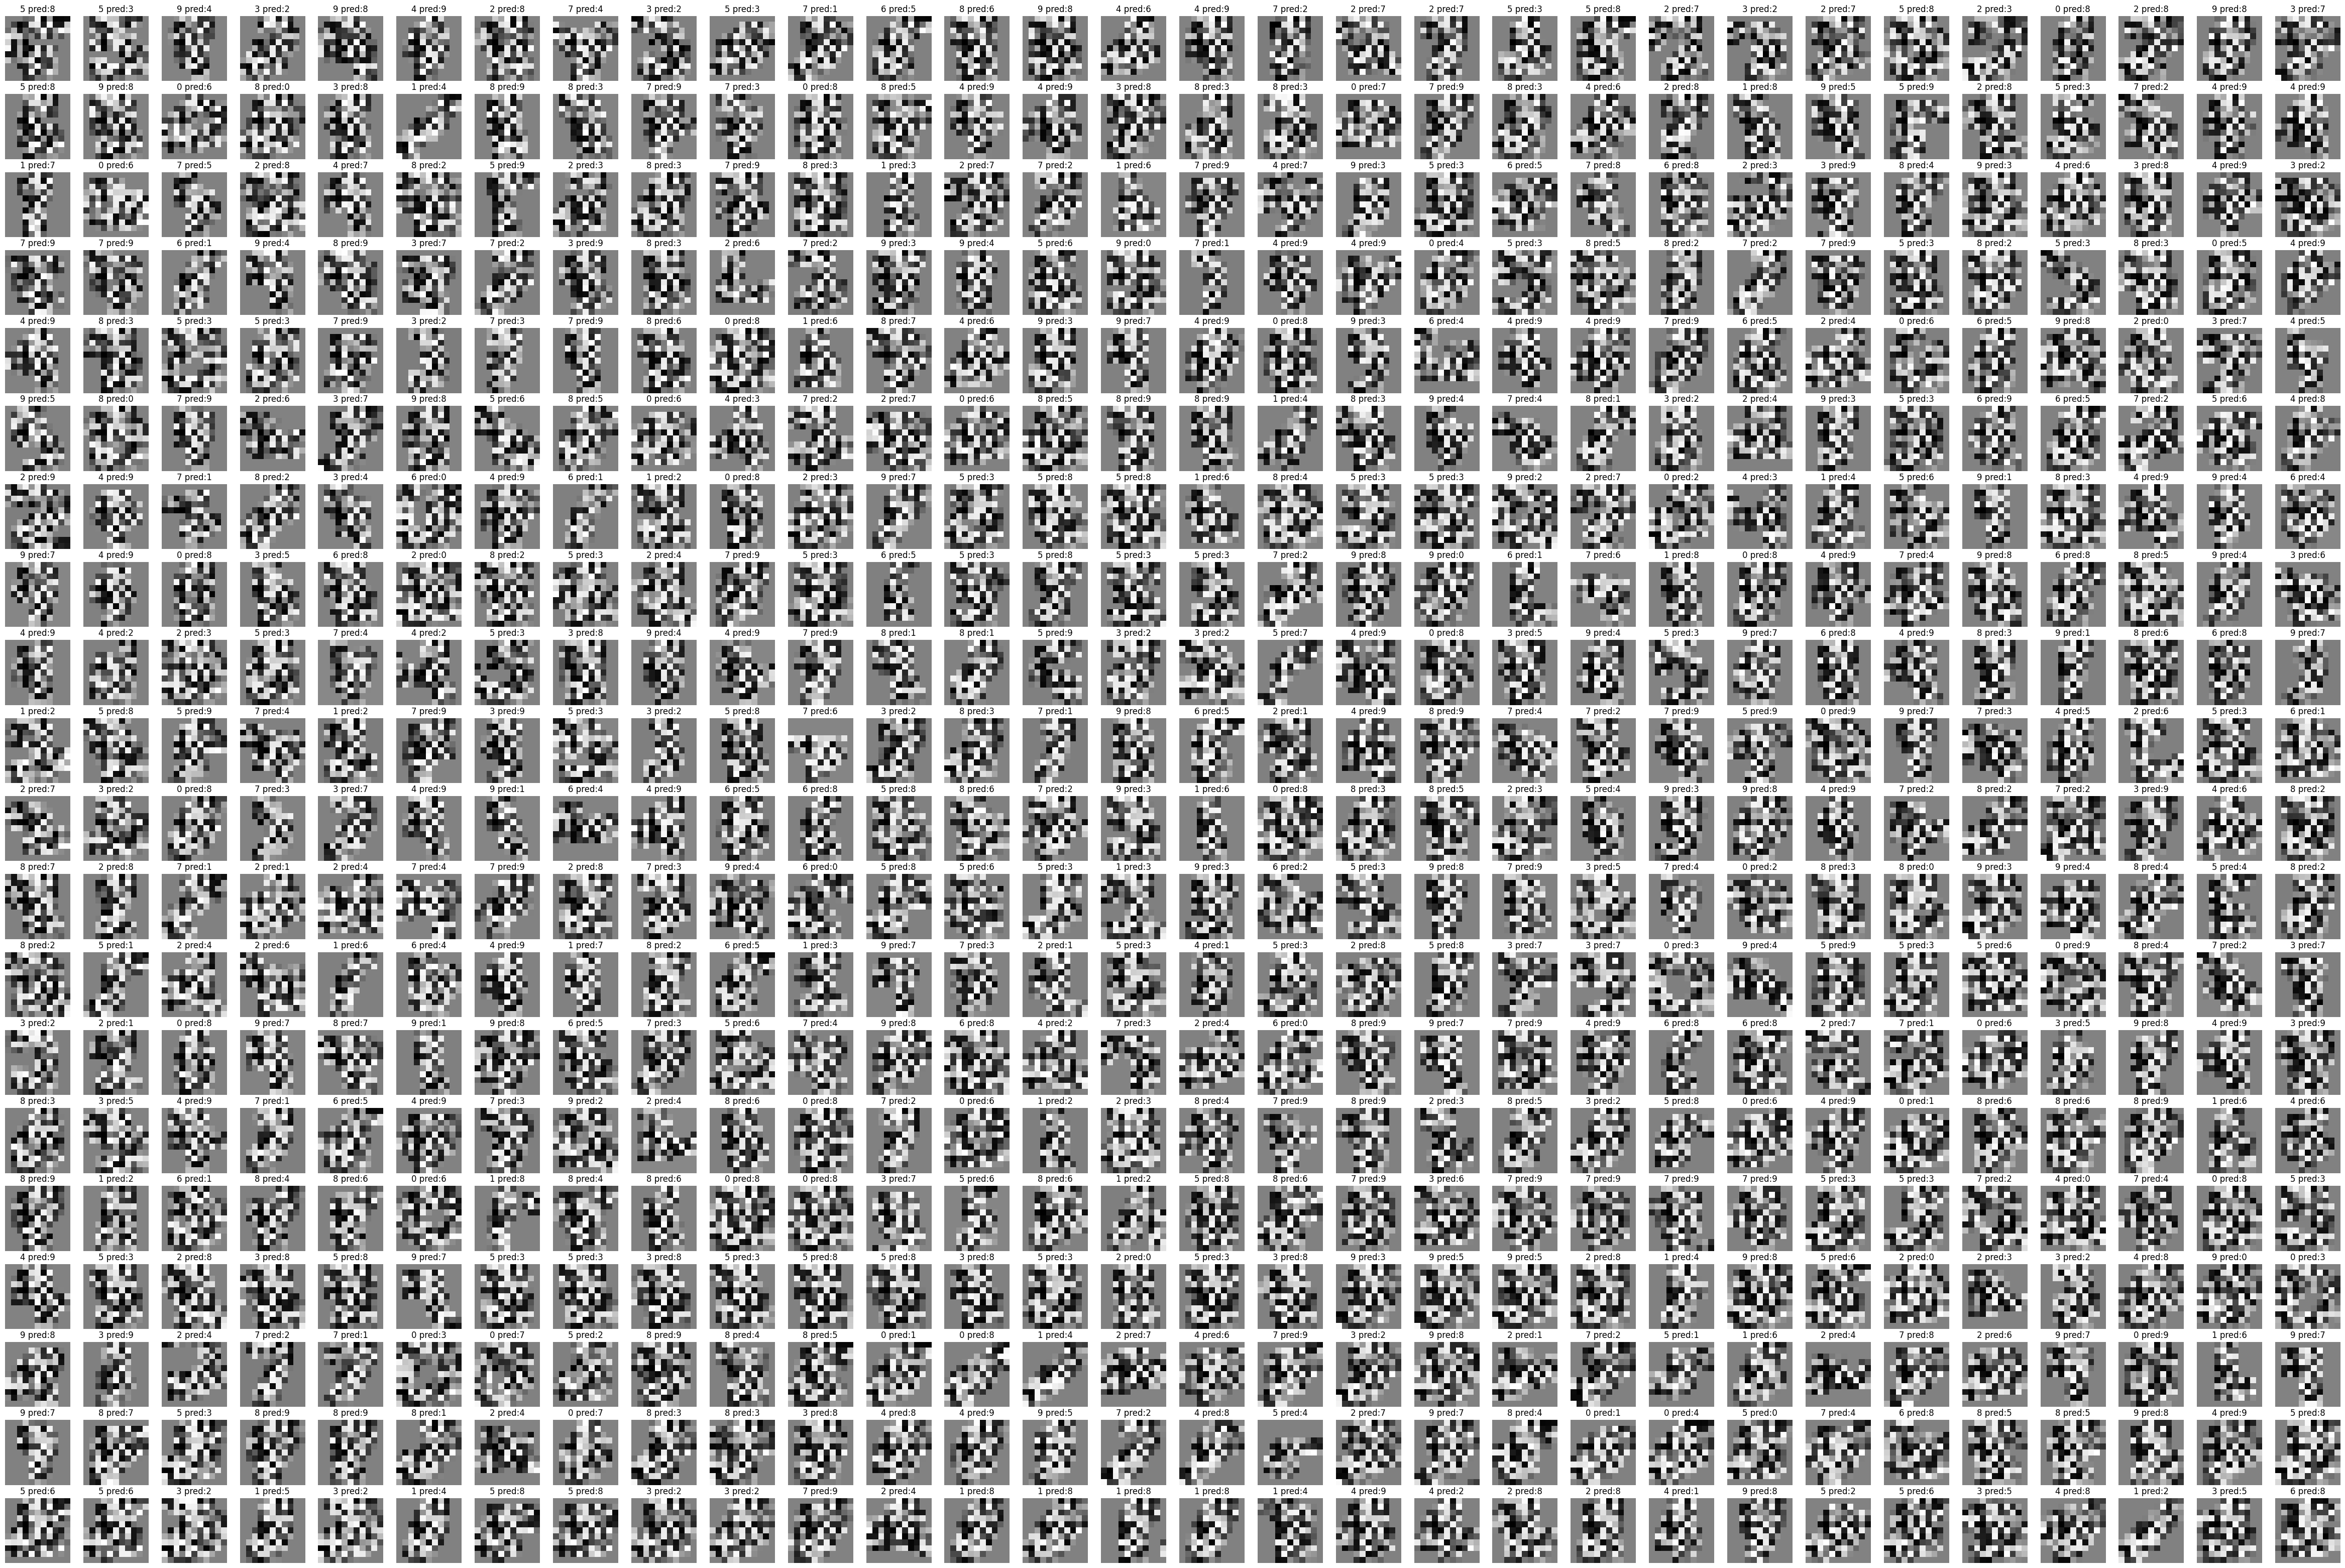

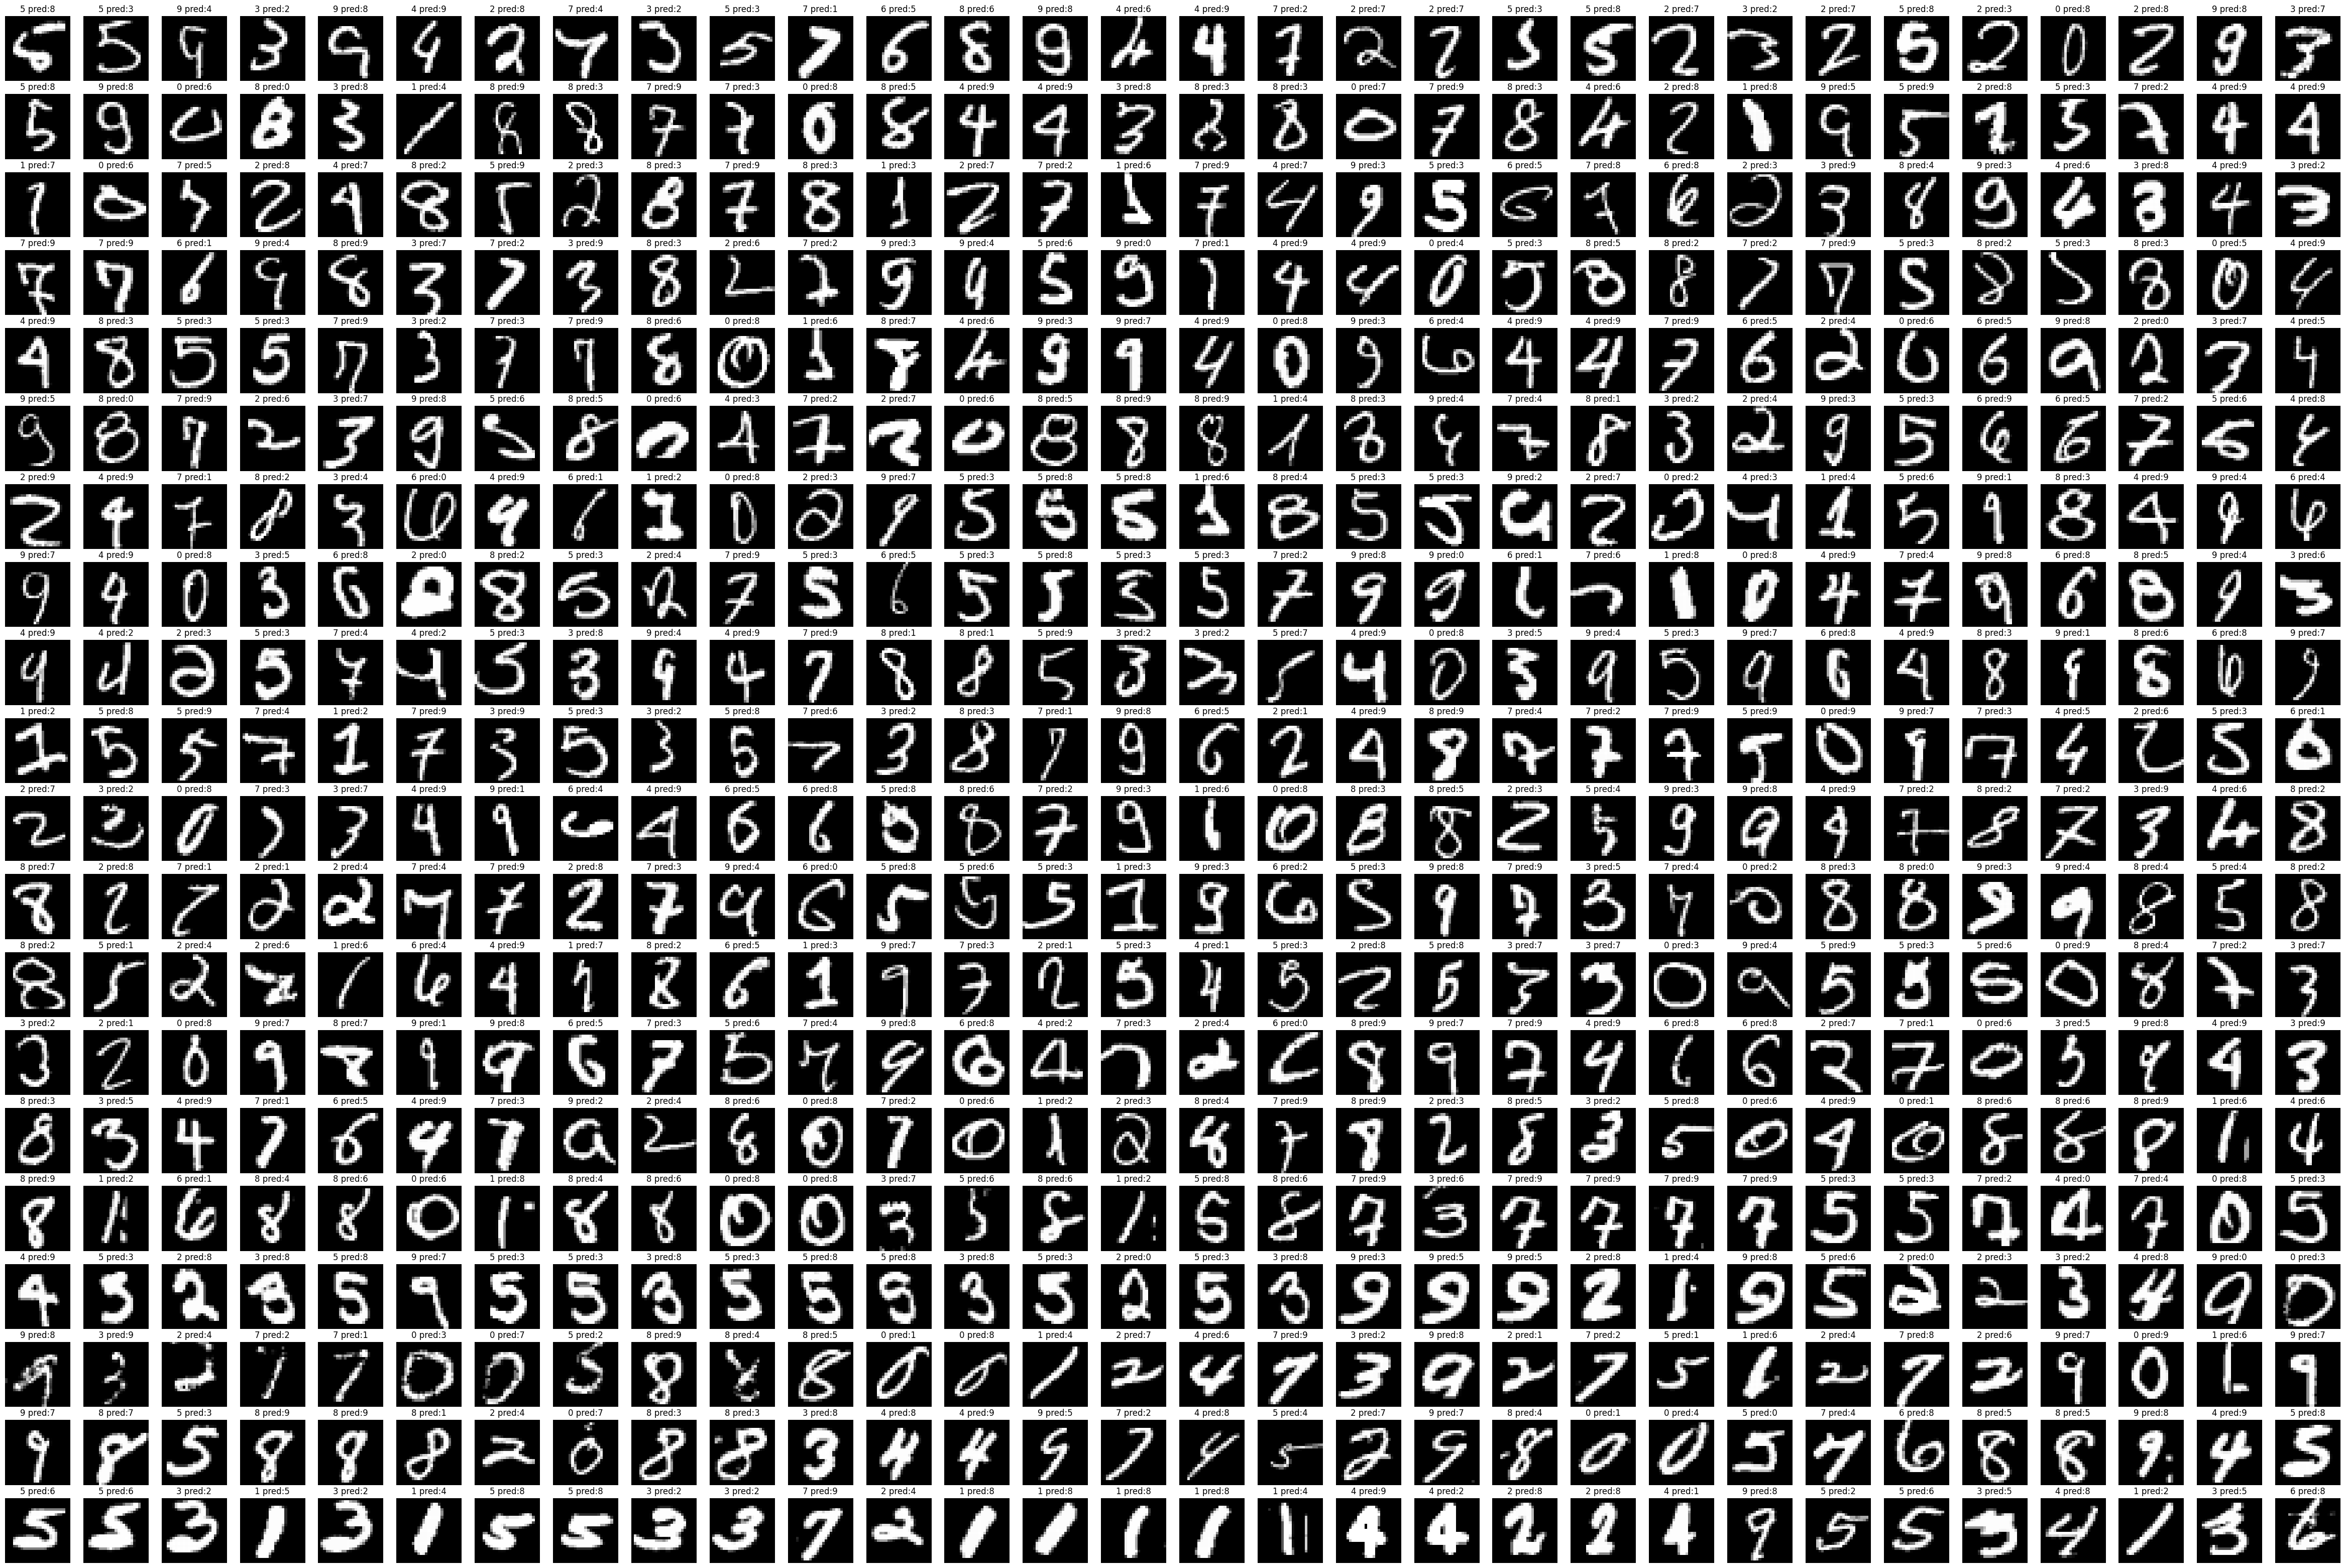

In [33]:
# plot sub_res in subplots (20*30)
ax, fig = plt.subplots(20, 30, figsize=(60, 40))
for i in range(20):
    for j in range(30):
        idx = i*30 + j
        fig[i, j].imshow(sub_ress[wrong_idx[idx]].reshape(11, 11), cmap='gray')
        fig[i, j].set_title(str(test_labels[wrong_idx[idx]].item()) + ' pred:' + str(test_pred[wrong_idx[idx]].item()))
        fig[i, j].axis('off')

plt.show()

# test_images and test_dataset have same order
test_images = np.load('data/mnist25_test.npy')
# plot and the wrong image use wrong_idx in subplots (20*30)
ax, fig = plt.subplots(20, 30, figsize=(60, 40))
for i in range(20):
    for j in range(30):
        idx = i*30 + j
        fig[i, j].imshow(test_images[wrong_idx[idx]].reshape(25,25), cmap='gray')
        fig[i, j].set_title(str(test_labels[wrong_idx[idx]].item()) + ' pred:' + str(test_pred[wrong_idx[idx]].item()))
        fig[i, j].axis('off')

plt.show()